# Anatomy of a critically acclaimed album

This project sets out to determine what features the top 200 albums in Pitchfork's article: "The 200 Best Albums of the 2010s" have in common. Additionally, this project will look at the features of these tracks and how they deviate from the average track.

Metrics used to evaluate albums/songs from this list will be pulled from Spotify's API. Features examined include genre, Spotify followers, popularity, and Spotify's audio feature metrics. These metrics are determined using predictive models and describe some of the abstract characteristics of the audio (energy, tempo, etc.)

## Data Cleaning

## Library Import

In [37]:
import pandas as pd
import sys
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['rank']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Connecting to Spotify API

In [7]:
%env SPOTIPY_CLIENT_ID='21c1b8031b824649882cc70268cb6d72'
%env SPOTIPY_CLIENT_SECRET='13872f23f56840e396124aaf02081b6e'
%env SPOTIPY_REDIRECT_URI='http://google.com/'

scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

util.prompt_for_user_token(username,
                           scope,
                           client_id='21c1b8031b824649882cc70268cb6d72',
                           client_secret='13872f23f56840e396124aaf02081b6e',
                           redirect_uri='http://google.com/')

token = util.prompt_for_user_token(username, scope)

spotify = spotipy.Spotify(auth=token)

env: SPOTIPY_CLIENT_ID='21c1b8031b824649882cc70268cb6d72'
env: SPOTIPY_CLIENT_SECRET='13872f23f56840e396124aaf02081b6e'
env: SPOTIPY_REDIRECT_URI='http://google.com/'


## Import Pitchfork data

Data has been scraped from the source article - https://pitchfork.com/features/lists-and-guides/the-200-best-albums-of-the-2010s/

In [8]:
pitchfork_df = pd.read_csv('datasets/pitchfork_top_200 (1).csv')

In [9]:
pitchfork_df.head()

,Rank,Artist,Album,Year
0,200,Ratking,So It Goes,2014
1,199,Wu Lyf,Go Tell Fire to the Mountain,2011
2,198,Jean Grae,Everything’s Fine,2018
3,197,Fatima Al Qadiri,Genre-Specific Xperience,2011
4,196,Portal,Vexovoid,2013


## Generate following data for each artist in Pitchfork list

Spotify assigns a unique id to each artist. Artist ids have been manually cleaned/verified. Spotify also has unique ids for each album, playlist, and track.

In [12]:
artist_ids = pd.read_csv('datasets/artist_ids.csv')

In [25]:
artist_ids['Artist'].head(10)

0             Ratking
1              Wu Lyf
2           Jean Grae
3    Fatima Al Qadiri
4              Portal
5       Downtown Boys
6    Titus Andronicus
7            Lil Peep
8              Kelela
9           Kate Bush
Name: Artist, dtype: object

## Pull following data from Spotify

In [14]:
ids = []
genres = []
followers = []
popularity = []
rank = rank = np.arange(1, 201, 1).tolist()
rank = rank[::-1]

for artist_name in artist_ids['id']:
    results = spotify.artist('spotify:artist:'+artist_name)
    ids.append(results['id'])
    genres.append(results['genres'])
    followers.append(results['followers']['total'])
    popularity.append(results['popularity'])

#Merge colunmns to create spotify df
artist_info = list(zip(ids, genres, followers, popularity, rank))
artist_info_df = pd.DataFrame(artist_info, columns = ['id', 'genre', 'followers', 'popularity', 'rank'])

In [15]:
#Merge dfs
pf_artist_info = pitchfork_df.merge(artist_info_df, left_on = 'Rank', right_on = 'rank')

In [16]:
#Search for album name, return album_id
spotify = spotipy.Spotify(auth=token)

alb_ids = artist_ids['album_id']

In [17]:
#Merge columns to create album_id/rank df
album_id_list = list(zip(alb_ids, rank))
album_id_df = pd.DataFrame(album_id_list, columns = ['album_id', 'rank'])

In [18]:
#For each album, return each track_id
album_id_track_level = []
track_id = []

for album in alb_ids:
    results = spotify.album_tracks('spotify:album:'+str(album))
    for i in range(len(results['items'])):
        album_id_track_level.append(album)
        track_id.append(results['items'][i]['id'])

In [19]:
#Merge columns to create album_id/track_id df
id_list = list(zip(album_id_track_level, track_id))
id_df = pd.DataFrame(id_list, columns = ['album_id', 'track_id'])

In [21]:
#Merge pf, artist, and album info into df
pf_artist_album_info = pf_artist_info.merge(album_id_df, on = 'rank')

In [29]:
pf_artist_album_info = pf_artist_album_info[['Rank', 'Artist', 'Album', 'id', 'genre', 'followers', 'popularity', 'album_id']]

In [30]:
pf_artist_album_info.head()

,Rank,Artist,Album,id,genre,followers,popularity,album_id
0,200,Ratking,So It Goes,2xtXCUTxmekNFB8oIYuOfe,[escape room],27171,31,3hXl1HiPIzbR1alZy3Eaf3
1,199,Wu Lyf,Go Tell Fire to the Mountain,5mGTnJvTkLDN76DgXka5f0,[chillwave],33907,32,3YUCk9Q1vjWsZsTur93sQP
2,198,Jean Grae,Everything’s Fine,2ipBhKpOYqs6BbysLNGye6,"[alternative hip hop, east coast hip hop, esca...",40597,43,22oHrB4SLwayyuLE02t5BD
3,197,Fatima Al Qadiri,Genre-Specific Xperience,1pfunEyqsC4oKSBY9gr8lN,"[arab electronic, art pop, deconstructed club,...",25649,30,3SHUtCuskxWnDgBHhupzaF
4,196,Portal,Vexovoid,1WiZz4d759EPtACSUBEfmt,"[australian black metal, australian metal, lov...",18518,24,0PtGwwqM6zFvawkY3JHtfq


In [23]:
#Export data to csv
pf_artist_album_info.to_csv('datasets/artist_info.csv')

## Pull song data from Spotify

Pull the following metrics from Spotify.

In [24]:
danceability = []
energy = []
key = []
loudness = []
mode = []
speechiness = []
acousticness = []
instrumentalness = []
liveness = []
valence = []
tempo = []
duration_ms = []
time_signature = []

for track in id_df['track_id']:

    result = spotify.audio_features(track)[0]
    try:
        danceability.append(result['danceability'])
    except:
        danceability.append(None)

    try:
        energy.append(result['energy'])
    except:
        energy.append(None)

    try:
        key.append(result['key'])
    except:
        key.append(None)

    try:
        loudness.append(result['loudness'])
    except:
        loudness.append(None)

    try:
        mode.append(result['mode'])
    except:
        mode.append(None)

    try:
        speechiness.append(result['speechiness'])
    except:
        speechiness.append(None)

    try:
        acousticness.append(result['acousticness'])
    except:
        acousticness.append(None)

    try:
        instrumentalness.append(result['instrumentalness'])
    except:
        instrumentalness.append(None)

    try:
        liveness.append(result['liveness'])
    except:
        liveness.append(None)

    try:
        valence.append(result['valence'])
    except:
        valence.append(None)

    try:
        tempo.append(result['tempo'])
    except:
        tempo.append(None)

    try:
        duration_ms.append(result['duration_ms'])
    except:
        duration_ms.append(None)

    try:
        time_signature.append(result['time_signature'])
    except:
        time_signature.append(None)

In [34]:
#Merge columns into song features df
features_list = list(zip(id_df['album_id'],
danceability,
energy,
key,
loudness,
mode,
speechiness,
acousticness,
instrumentalness,
liveness,
valence,
tempo,
duration_ms,))

features_df = pd.DataFrame(features_list, columns = ['album_id',
'danceability',
'energy',
'key',
'loudness',
'mode',
'speechiness',
'acousticness',
'instrumentalness',
'liveness',
'valence',
'tempo',
'duration_ms',])

In [35]:
features_df.head()

,album_id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,3hXl1HiPIzbR1alZy3Eaf3,0.343,0.981,10,-2.920,0,0.3930,0.007490,0.251000,0.152,0.365,159.337,237895
1,3hXl1HiPIzbR1alZy3Eaf3,0.493,0.852,2,-2.640,0,0.0731,0.000116,0.021700,0.514,0.395,135.284,183065
2,3hXl1HiPIzbR1alZy3Eaf3,0.258,0.969,7,-1.672,0,0.4050,0.003470,0.000043,0.628,0.473,175.756,402688
3,3hXl1HiPIzbR1alZy3Eaf3,0.426,0.733,2,-3.739,1,0.1720,0.051100,0.001260,0.294,0.268,159.645,282380
4,3hXl1HiPIzbR1alZy3Eaf3,0.485,0.920,6,-4.118,1,0.4150,0.147000,0.000000,0.194,0.448,127.809,188824


In [36]:
#Export data to csv
features_df.to_csv('datasets/spotify_features.csv')

# Data Exploration

## Data Import

In [38]:
#Import info on album and artist (including pitchfork ranking)
artist_df = pd.read_csv('datasets/artist_info.csv')

In [39]:
#Import song data from Spotify
song_df = pd.read_csv('datasets/spotify_features.csv')

## Data Exploration

### Year Distribution

In [58]:
year_dist = pd.DataFrame(np.array(np.unique(artist_df['Year'], return_counts=True)).T)

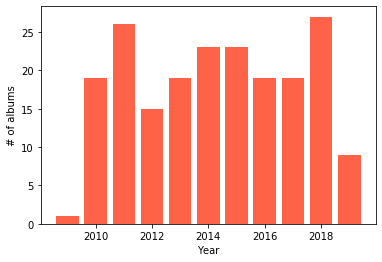

In [59]:
plt.bar(year_dist[0], year_dist[1], color = 'tomato')
plt.xlabel('Year')
plt.ylabel('# of albums')
plt.show()

### Key Distribution

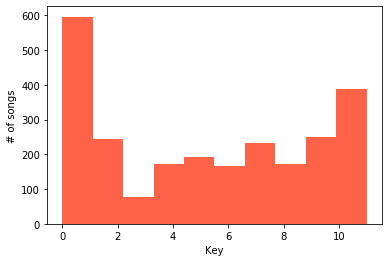

In [42]:
plt.hist(song_df['key'], color = 'tomato')
plt.xlabel('Key')
plt.ylabel('# of songs')
plt.show()

The overall estimated overall key of the track. Integers map to pitches using standard Pitch Class notation. E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.

The mode for this data is 1 which indicates "C" as the most popular key. This is also true for all music 

### Mode Distribution

In [61]:
mode_dist = pd.DataFrame(np.array(np.unique(song_df['mode'], return_counts=True)).T)

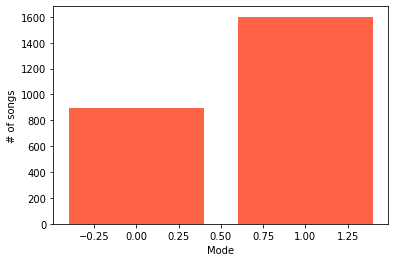

In [64]:
plt.bar(mode_dist[0], mode_dist[1], color = 'tomato')
plt.xlabel('Mode')
plt.ylabel('# of songs')
plt.show()

Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0. Based on some quick research, it looks as though the general distribution of popular songs is about 60% major, 40% minor. Roughly similar to what we're seeing here.

### Genre Distribution

In [65]:
#Genre distribution
artist_df['genre'].to_clipboard()
all_genre_info = ['escape room','chillwave','alternative hip hop', 'east coast hip hop', 'escape room', 'hip pop','arab electronic', 'art pop', 'deconstructed club', 'electra', 'escape room', 'experimental electronic', 'fluxwork', 'grave wave', 'witch house','australian black metal', 'australian metal', 'lovecraftian metal','rhode island indie','alternative rock', 'freak folk', 'indie punk', 'indie rock', 'lo-fi', 'new jersey indie','emo rap', 'lgbtq+ hip hop','afrofuturism', 'alternative r&b', 'art pop', 'dance pop', 'electropop', 'escape room', 'indie r&b', 'indie soul','art pop', 'art rock', 'baroque pop', 'dance rock', 'new wave pop', 'permanent wave', 'piano rock', 'singer-songwriter','ambient', 'art pop', 'deconstructed club', 'drone', 'dub techno', 'experimental synth', 'float house', 'microhouse', 'new isolationism', 'outsider house','contemporary country', 'country', 'country dawn', 'country road','gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap', 'underground hip hop', 'virginia hip hop','chamber psych', 'danish alternative rock', 'danish post-punk', 'garage psych', 'indie punk', 'indie rock','afrobeat', 'afropop', 'ethio-jazz', 'freak folk', 'funk', 'indie jazz', 'world','art pop', 'electropop', 'indie folk', 'indie pop', 'indie rock', 'small room','collage pop', 'deconstructed club', 'electra', 'fluxwork', 'new isolationism', 'outsider house','olympia wa indie', 'queercore','afrofuturism', 'alternative r&b', 'escape room', 'indie soul','electropop', 'indie pop', 'indie poptimism', 'indietronica', 'metropopolis', 'neo-synthpop', 'shimmer pop','afrofuturism', 'alternative hip hop', 'art pop', 'chillwave', 'escape room', 'experimental hip hop', 'freak folk', 'psychedelic hip hop', 'seattle hip hop', 'wonky','alternative country', 'folk', 'indie folk', 'nashville americana', 'new americana', 'outlaw country', 'roots rock', 'stomp and holler','conscious hip hop', 'funk', 'jazz funk', 'political hip hop', 'slam poetry', 'soul','art pop', 'british soul', 'dance pop', 'electropop', 'indie r&b', 'neo soul', 'pop', 'tropical house','art pop', 'chamber pop', 'chamber psych', 'freak folk', 'indie folk', 'indie pop', 'indie rock', 'melancholia', 'new americana', 'new jersey indie', 'stomp and holler','alternative country', 'new americana', 'new orleans americana', 'stomp and holler', 'traditional folk','dancehall', 'reggae fusion','alternative hip hop', 'escape room', 'experimental hip hop', 'hip hop', 'industrial hip hop', 'rap', 'underground hip hop','bass music', 'electronica', 'float house', 'future garage', 'intelligent dance music', 'mandible', 'microhouse', 'munich electronic', 'outsider house', 'wonky','candy pop', 'emo', 'pixie', 'pop emo', 'pop punk','ambient', 'ambient pop', 'art pop', 'chamber psych', 'chillwave', 'compositional ambient', 'drone', 'electra', 'experimental pop', 'fourth world', 'freak folk', 'indie folk', 'indietronica', 'melancholia','art pop', 'freak folk', 'garage psych', 'indie folk', 'indie garage rock', 'indie pop', 'indie rock', 'philly indie','dance pop', 'hip pop', 'pop', 'pop rap', 'post-teen pop', 'queens hip hop','art pop', 'bay area indie', 'chillwave', 'electropop', 'indie folk', 'indie pop', 'indie rock', 'indietronica', 'oakland indie', 'small room','alternative emo', 'art pop', 'emo', 'folk punk', 'indie pop', 'indie punk', 'indie rock', 'philly indie','hip hop', 'philly rap', 'pop rap', 'rap', 'southern hip hop', 'trap','alternative americana', 'indie folk', 'nashville singer-songwriter', 'new americana', 'outlaw country', 'roots rock','indie pop', 'modern alternative rock', 'nu gaze', 'pop', 'rock','alternative r&b', 'chicago rap', 'escape room', 'hip hop', 'indie soul', 'neo soul', 'rap', 'underground hip hop','doom metal', 'drone metal', 'epic doom', 'post-doom metal', 'psychedelic doom','alternative dance', 'art pop', 'brooklyn indie', 'dance-punk', 'electropop', 'escape room', 'experimental pop', 'indie pop', 'indie rock', 'indie surf', 'indietronica', 'modern rock', 'new rave', 'noise pop', 'shimmer pop','indie pop', 'modern alternative rock', 'nu gaze', 'pop', 'rock','art pop', 'indie folk', 'indie pop', 'indie rock', 'lilith','atl hip hop', 'rap', 'trap','british soundtrack', 'soundtrack','alternative country', 'alternative rock', 'anti-folk', 'freak folk', 'indie rock', 'lo-fi', 'modern power pop', 'slowcore','garage rock', 'modern rock', 'permanent wave', 'rock', 'sheffield indie','dance pop', 'pop','atl hip hop', 'hip hop', 'rap', 'trap', 'underground hip hop','edmonton indie','downtempo', 'electronica', 'microhouse','indie rock', 'modern rock','garage psych', 'indie punk', 'indie rock', 'philly indie','chicago drill', 'chicago rap', 'drill', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap', 'underground hip hop', 'vapor trap','alternative rock', 'art pop', 'art rock', 'chamber psych', 'indie rock', 'lilith', 'melancholia', 'permanent wave', 'piano rock', 'rock', 'singer-songwriter','art pop', 'experimental folk', 'freak folk', 'indie pop', 'indie rock','ambient', 'art pop', 'compositional ambient', 'drone', 'dub techno', 'electroacoustic improvisation', 'experimental', 'experimental guitar', 'fourth world', 'freak folk', 'glitch', 'intelligent dance music', 'mandible', 'microhouse', 'slowcore','dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap','alternative rock', 'brooklyn indie', 'denton tx indie', 'freak folk', 'garage psych', 'indie garage rock', 'indie rock', 'modern rock', 'neo-psychedelic', 'noise pop','ambient', 'berlin school', 'cleveland indie', 'drone', 'hauntology','alabama indie', 'indie rock', 'modern blues rock', 'rock','east coast hip hop', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap','ambient', 'art pop', 'canadian experimental', 'compositional ambient', 'drift', 'drone', 'dub techno', 'electronica', 'experimental', 'fourth world', 'freak folk', 'intelligent dance music', 'microhouse', 'new isolationism', 'warm drone','chamber pop', 'freak folk', 'indie folk', 'indie pop', 'indie rock', 'modern rock', 'seattle indie', 'stomp and holler','french shoegaze', 'metropopolis', 'neo-synthpop','bedroom pop', 'indie garage rock', 'indie pop', 'indie rock','art pop', 'chamber psych', 'freak folk', 'garage psych', 'indie folk', 'indie rock', 'modern psychedelic folk', 'neo-psychedelic', 'popgaze','hip hop', 'political hip hop','australian psych', 'neo-psychedelic','alternative rock', 'art rock', 'melancholia', 'oxford indie', 'permanent wave', 'rock','alternative rock', 'anti-folk', 'art pop', 'indie pop', 'indie punk', 'indie rock','alternative dance', 'art pop', 'chillwave', 'collage pop', 'experimental pop', 'freak folk', 'indie pop', 'indie rock', 'indietronica', 'noise pop', 'nu gaze','art pop', 'chamber psych', 'electropop', 'escape room', 'experimental pop', 'freak folk', 'hyperpop', 'indie r&b', 'indietronica','art pop', 'chillwave', 'freak folk', 'indie pop', 'indie rock', 'indietronica', 'lo-fi', 'new jersey indie', 'nu gaze', 'shimmer pop','atmospheric black metal', 'blackgaze', 'post-metal', 'usbm','art pop', 'baltimore indie', 'indie pop', 'indie rock','alternative emo', 'anthem emo', 'emo', 'indie punk', 'indie rock', 'midwest emo', 'new england emo', 'worcester ma indie','hip hop', 'rap','anti-folk', 'art pop', 'indie punk', 'indie rock','canadian singer-songwriter', 'folk', 'folk rock', 'melancholia', 'permanent wave', 'singer-songwriter','alternative hip hop', 'escape room', 'experimental hip hop', 'hip hop', 'industrial hip hop','afrofuturism', 'alternative r&b', 'art pop', 'atl hip hop', 'dance pop', 'electropop', 'escape room', 'neo soul', 'pop', 'r&b','alternative dance', 'art pop', 'chamber psych', 'chillwave', 'electropop', 'experimental pop', 'freak folk', 'indie rock', 'indietronica','indie r&b', 'indie soul','canadian indie', 'indie punk', 'indie rock', 'modern alternative rock', 'modern rock', 'noise pop', 'noise rock', 'vancouver indie', 'vancouver punk','electro', 'filter house','south dakota indie','atl hip hop', 'dirty south rap', 'gangster rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap','art pop', 'art rock', 'chamber psych', 'chillwave', 'collage pop', 'electra', 'escape room', 'experimental pop', 'freak folk', 'indie rock', 'la indie', 'slowcore','escape room', 'indie soul', 'lgbtq+ hip hop','art pop', 'brooklyn indie', 'chillwave', 'experimental pop', 'freak folk', 'indie folk', 'indie pop', 'indie rock', 'indietronica','alternative r&b', 'art pop', 'escape room', 'indie r&b', 'indie soul', 'la pop', 'neo soul','house', 'pop', 'tropical house', 'uk dance','alabama indie', 'art pop', 'electropop', 'freak folk', 'indie folk', 'indie pop', 'indie punk', 'indie rock', 'stomp and holler','art pop', 'deep latin alternative', 'freak folk','chicago rap', 'dance pop', 'pop', 'pop rap', 'r&b', 'southern hip hop', 'trap', 'urban contemporary','alternative dance', 'art pop', 'chillwave', 'electronica', 'electropop', 'indie pop', 'indietronica', 'modern dream pop', 'neo-synthpop', 'new rave','dance pop', 'pop', 'post-teen pop','latin', 'reggaeton', 'trap latino','alternative dance', 'balearic', 'deep house', 'electronica', 'new rave', 'norwegian space disco', 'nu disco','indie rock', 'modern rock', 'philly indie','alternative rock', 'art pop', 'chamber psych', 'dream pop', 'duluth indie', 'freak folk', 'melancholia', 'slowcore','art pop', 'chillwave', 'electronica', 'electropop', 'escape room', 'indie r&b', 'indie soul', 'indietronica','baroque pop', 'indie pop', 'indie rock', 'modern rock', 'rock','alternative r&b', 'art pop', 'chamber psych', 'electra', 'electronica', 'electropop', 'escape room', 'experimental pop', 'indie r&b', 'indie soul', 'uk contemporary r&b','east coast hip hop', 'hip hop', 'pop rap', 'rap','eau claire indie', 'indie folk', 'melancholia', 'slowcore','alternative emo', 'emo', 'indie garage rock', 'indie punk', 'indie rock','alternative dance', 'chillwave', 'electronica', 'electropop', 'folktronica', 'indie rock', 'indie soul', 'indietronica', 'intelligent dance music', 'new rave','art pop', 'chamber psych', 'electra', 'escape room', 'experimental pop', 'freak folk', 'norwegian experimental','hip hop', 'melodic rap', 'mississippi hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap','dance pop', 'indie pop', 'metropopolis', 'pop', 'pop rock', 'rock','ambient folk', 'art pop', 'chamber psych', 'freak folk', 'indie folk', 'indie rock','chicago rap', 'conscious hip hop', 'hip hop', 'pop rap', 'rap','bass music', 'dubstep', 'electronica', 'future garage', 'hauntology', 'intelligent dance music', 'microhouse', 'wonky','bay area indie', 'chillwave', 'freak folk', 'indie pop', 'indie rock', 'indie surf', 'noise pop', 'nu gaze','afrofuturism', 'alternative r&b', 'art pop', 'dance pop', 'electropop', 'escape room', 'hip pop', 'indie soul', 'neo soul', 'pop', 'r&b', 'urban contemporary','ambient', 'braindance', 'electronica', 'intelligent dance music', 'uk experimental electronic','australian psych', 'neo-psychedelic','alternative rock', 'freak folk', 'indie folk', 'indie rock', 'modern folk rock', 'neo-psychedelic', 'philly indie','alternative dance', 'electronica', 'folktronica', 'indie soul', 'indietronica', 'intelligent dance music', 'new rave','alternative dance', 'alternative rock', 'baroque pop', 'canadian indie', 'dance-punk', 'indie pop', 'indie rock', 'modern rock', 'new rave', 'permanent wave', 'quebec indie', 'rock','canadian contemporary r&b', 'canadian pop', 'pop','art pop', 'dance pop', 'deconstructed club', 'electropop', 'escape room', 'hyperpop', 'indietronica', 'transpop','pop', 'pop rap', 'rap','art pop', 'freak folk', 'indie folk', 'indie pop', 'indie rock', 'stomp and holler','art pop', 'dance pop', 'electropop', 'pop', 'pop rock', 'scandipop', 'swedish electropop', 'swedish pop','art pop', 'chamber pop', 'chamber psych', 'chillwave', 'electropop', 'experimental pop', 'freak folk', 'indie pop', 'indie rock', 'indietronica', 'seattle indie','canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap','afrofuturism', 'alternative hip hop', 'electronica', 'escape room', 'experimental hip hop', 'glitch', 'glitch hop', 'hip hop', 'indietronica', 'intelligent dance music', 'jazztronica', 'psychedelic hip hop', 'wonky','art pop', 'australian indie', 'indie pop', 'indie rock', 'melbourne indie','alternative dance', 'art pop', 'electronica', 'electropop', 'new rave', 'swedish electropop', 'swedish synth', 'swedish synthpop','atl hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap','art pop', 'brooklyn indie', 'escape room', 'indie pop', 'indie rock','alternative hip hop', 'detroit hip hop', 'escape room', 'hip hop', 'rap', 'southern hip hop', 'underground hip hop','ambient', 'ambient pop', 'art pop', 'chamber psych', 'chillwave', 'compositional ambient', 'dream pop', 'drone', 'electra', 'experimental ambient', 'experimental pop', 'fourth world', 'freak folk', 'modern dream pop', 'nu gaze', 'shoegaze', 'slowcore','art pop', 'chamber psych', 'dance pop', 'deconstructed club', 'electropop', 'escape room', 'experimental pop', 'fluxwork', 'indie r&b', 'indietronica','art pop','dance pop', 'pop', 'post-teen pop','afrofuturism', 'contemporary jazz', 'indie soul', 'jazz saxophone','conscious hip hop', 'hip hop', 'rap', 'west coast rap','alternative dance', 'art pop', 'dance pop', 'electronica', 'electropop', 'experimental pop', 'experimental vocal', 'icelandic experimental', 'icelandic pop', 'metropopolis', 'permanent wave', 'pop rock', 'trip hop','art pop', 'electropop', 'escape room', 'etherpop', 'indie pop', 'indie rock', 'indietronica', 'metropopolis','atl hip hop', 'atl trap', 'gangster rap', 'melodic rap', 'pop rap', 'rap', 'trap','afrofuturism', 'art pop', 'deconstructed club', 'electra', 'fluxwork', 'footwork', 'intelligent dance music','alternative dance', 'alternative rock', 'dance-punk', 'electronic rock', 'electronica', 'indie pop', 'indie rock', 'indietronica', 'modern rock', 'new rave', 'rock','deep house', 'electronica', 'float house', 'german techno', 'hamburg electronic', 'indie soul', 'microhouse', 'minimal techno', 'tech house','art pop', 'canadian electropop', 'chillwave', 'dance pop', 'electropop', 'grave wave', 'indietronica', 'metropopolis','ambient', 'art pop', 'chamber psych', 'chillwave', 'compositional ambient', 'drone', 'electronica', 'escape room', 'experimental pop', 'fluxwork', 'fourth world', 'freak folk', 'hauntology', 'indietronica', 'intelligent dance music', 'microhouse', 'outsider house', 'vaporwave', 'wonky','art pop', 'chamber psych', 'escape room', 'experimental pop', 'metropopolis', 'transpop','canadian pop', 'dance pop', 'electropop', 'indie poptimism', 'pop', 'post-teen pop','alternative dance', 'art pop', 'dance-punk', 'electroclash', 'electronica', 'electropop', 'gothenburg indie', 'neo-synthpop', 'new rave', 'swedish electropop', 'swedish synthpop','alternative rock', 'anti-folk', 'art pop', 'freak folk', 'indie folk', 'indie rock', 'lo-fi', 'melancholia', 'slowcore', 'washington indie','alternative hip hop', 'conscious hip hop', 'east coast hip hop', 'gangster rap', 'hardcore hip hop', 'hip hop', 'jazz rap', 'queens hip hop', 'rap','art pop', 'candy pop', 'dance pop', 'electropop', 'escape room', 'indietronica', 'la indie', 'metropopolis', 'neo-synthpop','afrofuturism', 'hip hop', 'neo soul', 'r&b', 'soul', 'urban contemporary','dance pop', 'pop', 'post-teen pop', 'r&b','candy pop', 'dance pop', 'electropop', 'escape room', 'metropopolis', 'pop', 'post-teen pop', 'uk pop','alternative country', 'anti-folk', 'art pop', 'chamber pop', 'freak folk', 'indie folk', 'indie rock', 'slowcore','alternative r&b', 'escape room','album rock', 'art rock', 'classic rock', 'dance rock', 'glam rock', 'permanent wave', 'rock','r&b en espanol','alternative r&b', 'art pop', 'chillwave', 'electropop', 'escape room', 'indie soul', 'indietronica', 'metropopolis','conscious hip hop', 'escape room', 'hip hop', 'rap', 'southern hip hop', 'underground hip hop','art pop', 'brooklyn indie', 'chamber pop', 'freak folk', 'indie folk', 'indie pop', 'indie rock', 'small room', 'stomp and holler','eau claire indie', 'indie folk', 'melancholia', 'slowcore','dance pop', 'pop', 'post-teen pop', 'r&b','art pop', 'brooklyn indie', 'escape room', 'indie pop', 'indie rock','alternative dance', 'alternative rock', 'art pop', 'atlanta indie', 'chamber psych', 'chillwave', 'dance-punk', 'dream pop', 'electronica', 'experimental rock', 'freak folk', 'garage psych', 'indie pop', 'indie rock', 'lo-fi', 'modern alternative rock', 'modern rock', 'neo-psychedelic', 'new rave', 'noise pop', 'noise rock', 'nu gaze', 'shoegaze', 'slowcore','afrofuturism', 'art pop', 'dance pop', 'electropop', 'escape room', 'indie r&b', 'pop', 'trip hop','alternative hip hop', 'escape room', 'experimental hip hop', 'hip hop', 'rap', 'underground hip hop','alternative americana', 'art pop', 'chamber psych', 'freak folk', 'indie pop', 'indie rock','electronica', 'future garage', 'indie soul', 'indietronica', 'new rave','pop', 'pop rap', 'rap','contemporary country', 'country dawn', 'pop', 'texas country','alternative dance', 'alternative rock', 'art pop', 'art rock', 'canadian indie', 'chamber pop', 'chamber psych', 'chillwave', 'freak folk', 'garage psych', 'indie folk', 'indie pop', 'indie rock', 'indietronica', 'noise pop', 'slowcore', 'stomp and holler', 'vancouver indie','art pop', 'baltimore indie', 'chillwave', 'dream pop', 'freak folk', 'indie pop', 'indie rock', 'indietronica', 'modern dream pop','bass music', 'footwork', 'ghettotech', 'outsider house','art pop', 'pop','conscious hip hop', 'hip hop', 'rap', 'west coast rap','baroque pop', 'chamber pop', 'freak folk', 'indie folk', 'singer-songwriter','chamber folk', 'chamber pop', 'freak folk', 'harp', 'new weird america','chicago rap', 'rap','art pop', 'dance pop', 'metropopolis', 'nz pop', 'pop','canadian hip hop', 'canadian pop', 'hip hop', 'pop rap', 'rap', 'toronto rap','barbadian pop', 'dance pop', 'pop', 'post-teen pop', 'r&b', 'urban contemporary','art pop', 'canadian electropop', 'chillwave', 'dance pop', 'electropop', 'grave wave', 'indietronica', 'metropopolis','alternative r&b', 'hip hop', 'lgbtq+ hip hop', 'neo soul', 'pop','alternative r&b', 'funk', 'hip hop', 'indie soul', 'neo soul', 'soul','art pop', 'dance pop', 'electropop', 'pop', 'pop rock', 'scandipop', 'swedish electropop', 'swedish pop','baroque pop', 'indie pop', 'indie rock', 'modern rock', 'rock','afrofuturism', 'alternative r&b', 'art pop', 'dance pop', 'electropop', 'escape room', 'hip pop', 'indie soul', 'neo soul', 'pop', 'r&b', 'urban contemporary','art pop', 'chamber pop', 'indie pop', 'lilith', 'permanent wave', 'piano rock', 'pop rock', 'singer-songwriter','conscious hip hop', 'hip hop', 'rap', 'west coast rap','dance pop', 'pop', 'post-teen pop', 'r&b','chicago rap', 'rap','alternative r&b', 'hip hop', 'lgbtq+ hip hop', 'neo soul', 'pop']
genre_freq = Counter(all_genre_info)
genre_count = pd.DataFrame.from_dict(genre_freq, orient='index').reset_index()
genre_count.head(10)

,index,0
0,escape room,36
1,chillwave,22
2,alternative hip hop,8
3,east coast hip hop,4
4,hip pop,4
5,arab electronic,1
6,art pop,73
7,deconstructed club,6
8,electra,8
9,experimental electronic,1


What is "escape room"? More info here: https://festivalpeak.com/what-is-escape-room-and-why-is-it-one-of-my-top-genres-on-spotify-a886372f003f

Other than this, hip hop and its subgenres appear to be the most prevalent, followed closely by electronic and its associated genres.

## Examining Spotify's predictive features.

For each section below, a feature of this list will be compared to that of the entire population of albums on spotify.

The blue graph has been pulled from Spotify's API and represents the distribution of all albums on the platform. The orange graph represents the tracks that make up each of the 200 albums. The goal of plotting these two graphs is to notice distinct differences between our top 200 list and the general population.

The descriptions for each of these features has been pulled straight from Spotify's API documentation.

For more info on these features, see the API documentation here: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

### Danceability

Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

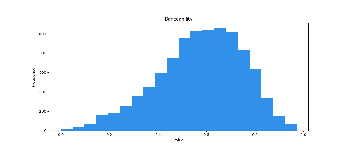

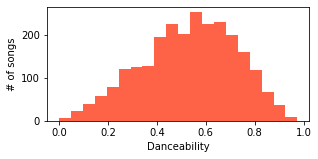

In [45]:
plt.figure(1)
plt.axis('off')
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/danceability.png')
plt.imshow(img)

plt.figure(2, figsize=(4.7,2.1))
plt.hist(song_df['danceability'], color = 'tomato', bins = 20)
plt.xlabel('Danceability')
plt.ylabel('# of songs')
plt.show()


### Energy

Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

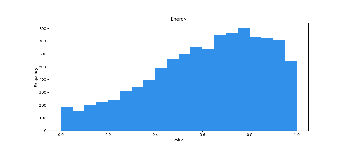

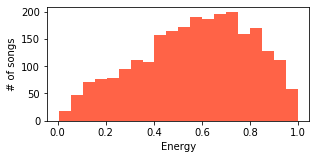

In [46]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/energy.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['energy'], color = 'tomato', bins = 20)
plt.xlabel('Energy')
plt.ylabel('# of songs')
plt.show()

### Loudness

The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

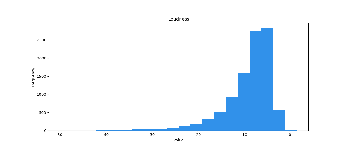

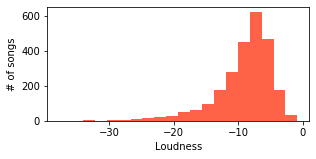

In [47]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/loudness.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['loudness'], color = 'tomato', bins = 20)
plt.xlabel('Loudness')
plt.ylabel('# of songs')
plt.show()

### Speechiness

Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

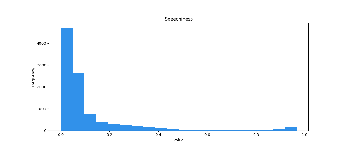

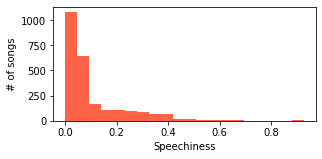

In [48]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/speechiness.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['speechiness'], color = 'tomato', bins = 20)
plt.xlabel('Speechiness')
plt.ylabel('# of songs')
plt.show()

### Acousticness

A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

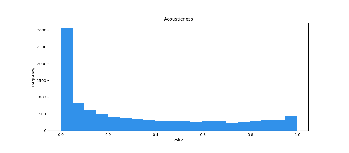

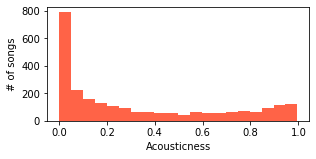

In [49]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/acousticness.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['acousticness'], color = 'tomato', bins = 20)
plt.xlabel('Acousticness')
plt.ylabel('# of songs')
plt.show()

### Instrumentalness

Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 

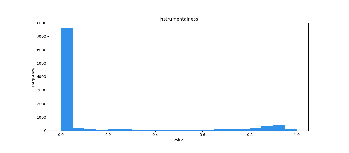

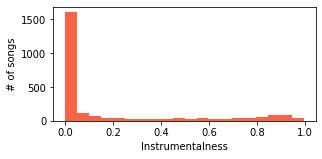

In [50]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/instrumentalness.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['instrumentalness'], color = 'tomato', bins = 20)
plt.xlabel('Instrumentalness')
plt.ylabel('# of songs')
plt.show()

### Liveness

Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. 

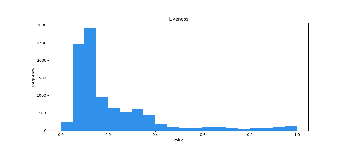

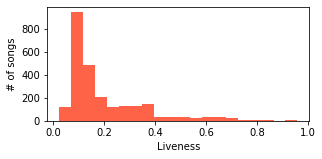

In [51]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/liveness.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['liveness'], color = 'tomato', bins = 20)
plt.xlabel('Liveness')
plt.ylabel('# of songs')
plt.show()

### Valence

A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

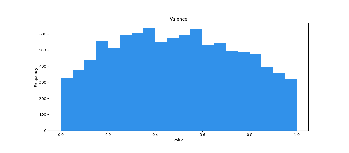

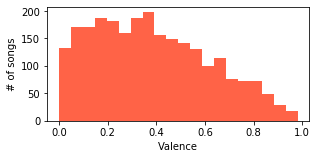

In [52]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/valence.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['valence'], color = 'tomato', bins = 20)
plt.xlabel('Valence')
plt.ylabel('# of songs')
plt.show()

### Tempo

The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. The distribution of values for this feature look like this:

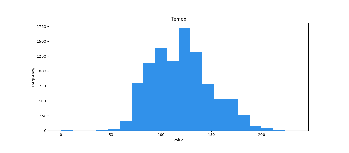

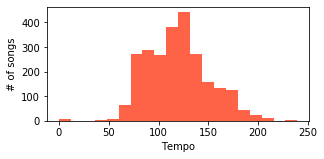

In [53]:
img=mpimg.imread('/Users/brianmcniff/Desktop/Spotify hists/tempo.png')
plt.imshow(img)
plt.axis('off')
plt.figure(figsize=(4.7,2.1))

plt.hist(song_df['tempo'], color = 'tomato', bins = 20)
plt.xlabel('Tempo')
plt.ylabel('# of songs')
plt.show()

### Duration (min)

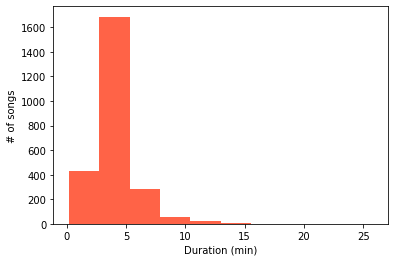

In [54]:
#Duration (min) Distrubution
plt.hist(song_df['duration_ms']/60000, color = 'tomato')
plt.xlabel('Duration (min)')
plt.ylabel('# of songs')
plt.show()

Based on the info in the charts above, it looks as though valence and energy have the largest discrepancy between these albums and the general library of music. Looking at both of these charts, albums from the top 200 tend to be skewed slightly more left than with general albums. This means albums that are less energetic,less intense, and convey a general sense of negativity (sadness, depression, anger) tend to resonate more with critics than that of other albums.

This paired with the knowledge that the most represented genre in this list is hip-hop implies that in order to get on the Best Album of the 2020's list, your best shot is a sad, low energy hip hop album.

To see the full list of albums, including critic's reasoning, see Pitchfork's article: https://pitchfork.com/features/lists-and-guides/the-200-best-albums-of-the-2010s/

For more information on Spotify's API and audio features, see their documentation: https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

To take a listen to the tracks this list has to offer, see this playlist which has taken tracks from each album represented in this list: https://open.spotify.com/playlist/5NOIhb4nrzrw15skiTKYEF
